# Ultimate Guide to Multiclass Classification With Sklearn
## Model selection, developing strategy and evaluation metrics
![](https://cdn-images-1.medium.com/max/1200/1*vlfX6cRLxZKhn4uN4MFHrg.jpeg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@sergiu-iacob-10475786?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Sergiu Iacob</a>
        on 
        <a href='https://www.pexels.com/photo/wave-dark-abstract-motion-7868341/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

### Introduction

Even though multi-class classification is not as common, it certainly poses a much bigger challenge than binary classification problems. You can literally take my word for it because this article has been the most challenging post I have ever written (have written close to 70).

I found that the topic of multiclass classification is deep and full of nuances. I have read so many articles, read multiple StackOverflow threads, created a few of my own, and spent several hours exploring the Sklearn user guide and doing experiments. The core topics of multiclass classification such as 

- choosing a strategy to binarize the problem
- choosing a base mode
- understanding excruciatingly many metrics 
- filtering out a single metric that solves your business problem and customizing it
- tuning hyperparameters for this custom metric
- and finally putting all the theory into practice with Sklearn

have all been scattered in the dark, sordid corners of the Internet. This was enough to conclude that no single resource shows an end-to-end workflow of dealing with multiclass classification problems on the Internet (maybe, I missed it).

For this reason, this article will be a comprehensive tutorial on how to solve any multiclass supervised classification problem using Sklearn. You will learn both the theory and the implementation of the above core concepts. It is going to be a long and technical read, so get a coffee!

### Estimators that support mutliclass classification natively

Depending on the model you choose, Sklearn approaches multiclass classification problems in 3 different ways. In other words, Sklearn estimators are grouped into 3 categories by their strategy to deal with multi-class data.

The first and the biggest group of estimators are the ones that support multi-class classification natively:

- [`naive_bayes.BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
- [`tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- [`tree.ExtraTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html#sklearn.tree.ExtraTreeClassifier)
- [`ensemble.ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier)
- [`naive_bayes.GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
- [`neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [`svm.LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) (setting multi_class=”crammer_singer”)`
- [`linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (setting multi_class=”multinomial”)
- [`linear_model.LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV) (setting multi_class=”multinomial”)

For N-class problem, they produce N by N [confusion matrix](https://towardsdatascience.com/how-to-tune-models-like-a-puppet-master-based-on-confusion-matrix-fd488f9b5e65?source=your_stories_page-------------------------------------) and most of the evaluation metrics are derived from it:

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

# Build a synthetic dataset
X, y = make_classification(
    n_samples=1000, n_features=5, n_informative=4, n_redundant=1, n_classes=4
)

# Train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1121218
)

# Fit/predict
etc = ExtraTreesClassifier()
_ = etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["class_1", "class_2", "class_3", "class_4"],
)

cmp.plot(ax=ax)
plt.show();

We will focus on multiclass confusion matrices later in the tutorial.

### Binary classifiers that support mutliclass classification with One-vs-One (OVO) strategy

Other supervised classification algorithms were mainly designed for the binary case. However, Sklearn implements two strategies called One-vs-One (OVO) and One-vs-Rest (OVR, also called One-vs-All) to convert a multi-class problem into a series of binary tasks.

OVO splits a multi-class problem into a single binary classification task for each pair of classes. In other words, for each pair, a single binary classifier will be built. For example, a target with 4 classes - brain, lung, breast, and kidney cancer, uses 6 individual classifiers to binarize the problem:

- Classifier 1: lung vs breast
- Classifier 2: lung vs kidney
- Classifier 3: lung vs brain
- Classifier 4: breast vs kidney
- Classifier 5: breast vs brain
- Classifier 6: kidney vs brain

Sklearn suggests these classifiers to work best with OVO approach:

- [svm.NuSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC)
- [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- [gaussian_process.GaussianProcessClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier) (setting multi_class = “one_vs_one”)

Sklearn also provides a wrapper estimator for the above models under `sklearn.multiclass.OneVsOneClassifier`:

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

# Don't have to set `multi_class` argument if used with OVOClassifier
ovo = OneVsOneClassifier(estimator=GaussianProcessClassifier())

ovo.fit(X_train, y_train)

A major downside of this strategy is its computation workload. As each pair of classes require a separate binary classifier, targets with high cardinality may take too long to train. To compute the number of classifiers that will be built for an N-class problem, the following formula is used:

![](https://cdn-images-1.medium.com/max/800/1*uU3BK3dicsDL6ajnpVX60Q.png)

In [ ]:
# Print the number of estimators created
print(len(ovo.estimators_))

In practice, One-vs-Rest strategy is much preferred because of this disadvantage.

### Binary classifiers that support mutliclass classification with One-vs-Rest (OVR) strategy

Alternatively, the OVR strategy creates an individual classifier for each class in the target. Essentially, each binary classifier chooses a single class and marks it as positive, encoding it as 1. The rest of the classes are considered negative labels and, thus, encoded with 0. For classifying 4 types of cancer:

- Classifier 1: lung vs. \[breast, kidney, brain\] - (lung cancer, not lung cancer)
- Classifier 2: breast vs. \[lung, kidney, brain\] - (breast cancer, not breast cancer)
- Classifier 3: kidney vs. \[lung, breast, brain\] -  (kidney cancer, not kidney cancer)
- Classifier 4: brain vs. \[lung, breast kidney\] - (brain cancer, not brain cancer)

Sklearn suggests these classifiers to work best with OVR approach:

- [`ensemble.GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)
- [`gaussian_process.GaussianProcessClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier) (setting multi_class = “one_vs_rest”)
- [`svm.LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) (setting multi_class=”ovr”)
- [`linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (setting multi_class=”ovr”)
- [`linear_model.LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV) (setting multi_class=”ovr”)
- [`linear_model.SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)
- [`linear_model.Perceptron`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron)

Alternatively, you can use the above models with the default `OneVsRestClassifier`:

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsRestClassifier

# Init/fit
ovr = OneVsRestClassifier(estimator=Perceptron())
_ = ovr.fit(X_train, y_train)

In [ ]:
print(len(ovr.estimators_))

Even though this strategy significantly lowers the computational cost, the fact that only one class is considered positive and the rest as negative makes each binary problem an imbalanced classification. This problem is even more pronounced for classes with low proportions in the target.

In both approaches, depending on the passed estimator, the results of all binary classifiers can be summarized in two ways:
- majority of the vote: each binary classifier predicts one class and the class that got the most votes from all classifiers is chosen
- depending on the argmax of class membership probability scores: classifiers such as LogisticRegression computes probability scores for each class (`.predict_proba()`). Then, the argmax of the sum of the scores is chosen.

We will talk more about how to score each of these strategies later in the tutorial.

### Sample classification problem and preprocessing pipeline

As an example problem, we will be predicting the quality of diamonds using the [Diamonds dataset](https://www.kaggle.com/shivam2503/diamonds) from Kaggle:

In [ ]:
import pandas as pd

diamonds = pd.read_csv("../input/diamonds/diamonds.csv").drop("Unnamed: 0", axis=1)
diamonds.head()

In [ ]:
diamonds.shape

In [ ]:
diamonds.describe().T.round(3)

The above output shows the features are on different scales, suggesting we use some type of normalization. This step is essential for many linear-based models to perform well.

In [ ]:
diamonds.cut.value_counts()

The dataset contains a mixture of numeric and categorical features. I covered preprocessing steps for binary classification in my [last article](https://towardsdatascience.com/how-to-tune-models-like-a-puppet-master-based-on-confusion-matrix-fd488f9b5e65?source=your_stories_page-------------------------------------) in detail. You can easily apply the ideas to the multi-class case, so I will keep the explanations here nice and short.

The target is 'cut', which has 5 classes: Ideal, Premium, Very Good, Good, and Fair (descending quality). We will encode the textual features with OneHotEncoder. 

Let's take a quick look at the distributions of each numeric feature to decide what type of normalization to use:

In [ ]:
diamonds.hist(figsize=(16, 12));

Price and carat shows skewed distributions. We will use a logarithmic transformer to make them as normally-distributed as possible. For the rest, simple standardization is enough. If you are not familiar with numeric transformations, check out my [article](https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94?source=your_stories_page-------------------------------------) on the topic. Also, below code contains an example of Sklearn pipelines and you can learn all about them from [here](https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d?source=your_stories_page-------------------------------------). Let's get to work:

In [ ]:
from sklearn.model_selection import train_test_split

# Build feature/target arrays
X, y = diamonds.drop("cut", axis=1), diamonds["cut"].values.flatten()

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1121218, test_size=0.33, stratify=y
)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler

# Build categorical preprocessor
categorical_cols = X.select_dtypes(include="object").columns.to_list()
categorical_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))


# Build numeric processor
to_log = ["price", "carat"]
to_scale = ["x", "y", "z", "depth", "table"]
numeric_pipe_1 = make_pipeline(PowerTransformer())
numeric_pipe_2 = make_pipeline(StandardScaler())

# Full processor
full = ColumnTransformer(
    transformers=[
        ("categorical", categorical_pipe, categorical_cols),
        ("power_transform", numeric_pipe_1, to_log),
        ("standardization", numeric_pipe_2, to_scale),
    ]
)

# Final pipeline combined with RandomForest
pipeline = Pipeline(
    steps=[
        ("preprocess", full),
        (
            "base",
            RandomForestClassifier(max_depth=13),
        ),
    ]
)

In [ ]:
# Fit
_ = pipeline.fit(X_train, y_train)

The first version of our pipeline uses `RandomForestClassifier`. Let's look at its confusion matrix by generating predictions:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = pipeline.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)

plt.show();

In lines 8 and 9, we are creating the matrix and using a special Sklearn function to plot it. `ConfusionMatrixDisplay` also has `display_labels` argument, which we are passing the class names accessed by `pipeline.classes_` attribute.

### Interpreting N by N confusion matrix

If you read my [other article](https://towardsdatascience.com/how-to-tune-models-like-a-puppet-master-based-on-confusion-matrix-fd488f9b5e65?source=your_stories_page-------------------------------------) on binary classification you know that confusion matrices are the holy grail of supervised classification problems. In a 2 by 2 matrix, the matrix terms are easy to interpret and locate. 

Even though it gets more difficult to interpret the matrix as the number of classes increase, there are sure-fire ways to find your way around any matrix of any shape. 

The first step is always identifying your positive and negative classes. This depends on the problem you are trying to solve. As a jewelry store owner, I may want my classifier to differentiate Ideal and Premium diamonds better than other types, which makes these type of diamonds my positive class. Other classes will be considered negative. 

Establishing positive and negative classes early on is very important in evaluating model performance and in hyperparameter tuning. After doing this, you should define what are your true positives, true negatives, false positives and false negatives. In our case:

* Positive classes: Ideal and Premium diamonds
* Negative classes: Very Good, Good and Fair diamonds

- True Positives, type 1: actual Ideal, predicted Ideal
- True Positives, type 2: actual Premium, predicted Premium
- True Negatives: the rest of the diamond types predicted correctly
- False Positives: actual value belongs any of the 3 negative classes but predicted either Ideal or Premium
- False Negatives: actual value is either Ideal or Premium but predicted any of the 3 negative classes.

Always list out the terms of your matrix in this manner and the rest of your workflow will be much easier, as you will see in the next section.

### How Sklearn computes multiclass classification metrics - ROC AUC score

This section is only about the nitty-gritty details of how Sklearn calculates common metrics for multiclass classification. Specifically, we will peek under the hood of 4 most common metrics: ROC_AUC, precision, recall and f1 score. Even though I will give a brief overview of what each metric is, I will mostly focus on how you can use them in your own workflow. If you want a deeper explanation of what each metric measures, please refer to this [article](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2).

The first metric we will discuss is the ROC AUC score or area under the *receiver operating characteristic curve*. It is mostly used when we want to measure a classifier's performance to differentiate between each class. This means that ROC AUC is better suited for balanced classification tasks. In essence, ROC AUC score is used for binary classification and with models that can generate class membership probabilities based on some threshold. Here is the brief overview of the steps to calculate ROC AUC for binary classification:
1. A binary classifier that can generate class membership probabilities such as LogisticRegression with its `predict_proba` method.
2. An initial, close to 0 decision threshold is chosen. For example, if the probability is higher than 0.1, the class is predicted negative else positive.
3. Using this threshold, a confusion matrix is created.
4. True positive rate (TPR) and false positive rate (FPR) is found.
5. A new threshold is chosen and steps 3-4 are repeated.
6. Repeat the steps 2-5 for various thresholds between 0 and 1 to create a set of TPRs and FPRs.
7. Plot all TPRs vs FPRs to generate the receiver operating characteristic curve.
8. Calculate the area under this curve.

For multiclass classification, you can calculate the ROC AUC for all classes using either OVO or OVR strategies. Since we agreed that OVR is a better option, here is how ROC AUC is calculated for OVR classification:

1. Each binary classifier created using OVR finds the ROC AUC score for its own class using the above steps.
2. ROC AUC scores of all classifiers is then averaged using either of these 2 methods:
 - "macro": this is simple the arithmetic mean of the scores
 - "weighted": this takes class imbalance into account by finding a weighted average. Each ROC AUC is multiplied by their class weight and summed, then divided by the total number of samples.

As an example, let's say there are 100 samples in the target - class 1 (45), class 2 (30), class 3 (25). OVR creates 3 binary classifiers, 1 for each class and their ROC AUC scores are 0.75, 0.68, 0.84, respectively. The weighted ROC AUC score across all classes will be:

**ROC AUC (weighted): ((45 \* 0.75) + (30 \* 0.68) + (25 \* 0.84)) / 100 = 0.7515**

Here is the implementation of all this in Sklearn:

In [ ]:
from sklearn.metrics import roc_auc_score

# Generate membership scores with .predict_proba
y_pred_probs = pipeline.predict_proba(X_test)

# Calculate ROC_AUC
roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted")

Above, we calculated ROC AUC for our diamond classification problem and got a very good score. Don't forget to set the `multi_class` and `average` parameters properly when using `roc_auc_score`. If you want to to generate the score for a particular class, here is how you do it:

In [ ]:
# GENERATE ROC_AUC SCORE FOR 'IDEAL' CLASS DIAMONDS

# Find the index of Ideal class diamonds
idx = np.where(pipeline.classes_ == "Ideal")[0][0]

# Don't have to set multiclass and average params
roc_auc_score(y_test == "Ideal", y_pred_probs[:, idx])

ROC AUC score is only a good metric to see how the classifier differentiates between classes. A higher ROC AUC score does not necessarily mean a better model. On top of that, we care more about our model's ability to classify Ideal and Premium diamonds, so a metric like ROC AUC is not a good option for our case.

### Precision, Recall and F1 scores for multiclass classification

A better metric to measure our pipeline's performance would be using either precision, recall and F1 scores. For the binary case, they are easy and intuitive to understand:

![](https://cdn-images-1.medium.com/max/400/1*KWZHeEuBGhDfw5CTE_PRfQ.png)
![](https://cdn-images-1.medium.com/max/400/1*LmttOOk86tXBGlaC_73Xag.png)
![](https://cdn-images-1.medium.com/max/600/1*XH-bmDiJ50rWfqBR82NOdQ.png)

In multiclass case, these 3 metrics are calculated *per-class* basis. For example, let's look at the confusion matrix again:

In [ ]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)
cmp.plot(ax=ax)

plt.show();

Precision tells us what proportion of predicted positives is truly positive. If we want to calculate precision for Ideal diamonds, true positives would be the number of Ideal diamonds predicted correctly (the center of the matrix, 6626). False positives would be any cells that count the number of times our classifier predicted other type of diamonds as Ideal. These would be the cells above and below the center of the matrix (1013 + 521 + 31 + 8 = 1573). Using the formula of precision, we calculate it to be:

**Precision (Ideal) = TP / (TP + FP) = 6626 / (6626 + 1573) = 0.808**

Recall is calculated in a similar manner. We know the number of true positives - 6626. False negatives would be any cells that count the number of times the classifier predicted Ideal type of diamonds belonging to any other negative class. These would be the cells right and left to the center of the matrix (3 + 9 + 363 + 111 = 486). Using the formula of recall, we calculate it to be:

**Recall (Ideal) = TP / (TP + FN) = 6626 / (6626 + 486) = 0.93**

So, how do we choose between recall and precision for the Ideal class? It depends on the type of the problem you are trying to solve. If you want to minimize the instances where other, cheaper type of diamonds are predicted as Ideal, you should optimize precision. As a jewelry store owner, you might be sued for fraud for selling cheaper diamonds as expensive Ideal diamonds.

On the other hand, if you want to minimize the instances where you accidentally sell Ideal diamonds for a cheaper price, you should optimize for recall of the Ideal class. It is true that you won't get sued but you might lose money. 

The third option is to have a model that is equally good at the above 2 scenarios. In other words, a model with high precision and recall. Fortunately, there is a metric that measures just that: F1 score. F1 score takes the harmonic mean of precision and recall and produces a value between 0 and 1:
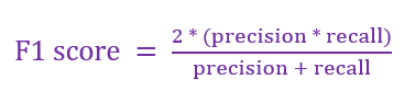

So, the F1 score for the Ideal class would be:

**F1 (Ideal) = 2 * (0.808 * 0.93) / (0.808 + 0.93) = 0.87**

Up to this point, we calculated the 3 metrics only for the Ideal class. But in multiclass classification, Sklearn computes them for all classes. You can use `classification_report` to calculate these metrics for all classes:

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

You can check that our calculations for the Ideal class were correct. The last column of the table, `support` shows how many samples are there for each class. Also, last 2 rows shows averaged scores for the 3 metrics. We already covered what macro and weighted averages are in the example of ROC AUC.

For imbalanced classification tasks such as these, you rarely choose averaged precision, recall of F1 scores. Again, choosing one metric to optimize for a particular class depends on your business problem. For our case, we will choose to optimize the F1 score of Ideal and Premium classes (yes, you can choose multiple classes at the same time). First, let's see how to calculate weighted F1 across all class:

In [ ]:
from sklearn.metrics import f1_score

# Weighed F1 across all classes
f1_score(y_test, y_pred, average="weighted")

The above is consistent with the output of `classification_report`. To choose the F1 scores for Ideal and Premium classes, specify the `labels` parameter:

In [ ]:
# F1 score for Ideal and Premium with weighted average
f1_score(y_test, y_pred, labels=["Premium", "Ideal"], average="weighted")

Finally, let's see how to optimize these metrics with hyperparameter tuning.

### Hyperparameter tuning to optimize model performance for a custom metric

Optimizing the model performance for some metric is almost the same as when we did for the binary case. The only difference is how we pass a scoring function to hyperparamter tuner like GridSearch. 

Up until now, we were using RandomForestClassifier pipeline, so we will create a hyperparameter grid for this estimator:

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)] + [None]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]

param_grid = {
    "base__n_estimators": n_estimators,
    "base__max_features": max_features,
    "base__max_depth": max_depth,
    "base__min_samples_split": min_samples_split,
    "base__min_samples_leaf": min_samples_leaf,
    "base__bootstrap": bootstrap,
}

> Don't forget to prepend each hyperparameter name with the step name you chose in the pipeline for your estimator. When we created our pipeline, we specified RandomForests as 'base'. See [this](https://stackoverflow.com/a/66344804/11922237) discussion for more info.

We will use the HalvingGridSeachCV (HGS) which was proven to be much faster than a regular GridSearch. You can read this article to see my experiments:

https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155

Before we feed the grid to HGS, let's create a custom scoring function. In binary case, we could pass string values as the names of the metrics we wanted to use such as 'precision' or 'recall'. But in multiclass case, those functions accept additional parameters and we cannot do that if we pass the function names as strings. To solve this, Sklearn provides `make_scorer` function:

In [ ]:
from sklearn.metrics import make_scorer

custom_f1 = make_scorer(f1_score, average="weighted", labels=["Ideal", "Premium"])

custom_f1

As we did in the last section, we passed the metric function along with custom values for `average` and `labels` parameters.

Finally, let's initialize the HGS and fit it to the full data with 3-fold cross-validation:

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV


# hgs = HalvingRandomSearchCV(
#     estimator=pipeline,
#     param_distributions=param_grid,
#     scoring=custom_f1,
#     cv=3,
#     n_candidates="exhaust",
#     factor=5,
#     n_jobs=-1,
# )

# _ = hgs.fit(X, y)

# model = hgs.best_estimator_

# _ = model.fit(X_train, y_train)
# preds = model.predict(X_test)

# f1_score(y_test, preds, average="weighted", labels=["Ideal", "Premium"])

After the search is done, you can get the best score and estimator with `.best_score_` and `.best_estimator_` attributes, respectively.

Your model is only as good as the metric you choose to evaluate it with. Hyperparameter tuning will be time-consuming but assuming you did everything right until this point and gave a good enough parameter grid, everything will turn out as expected. If not, it is an iterative process, so take your time by tweaking the preprocessing steps, take a second look at your chosen metrics and maybe widen your search grid. Thank you for reading!

### Related Articles

- [Multi-Class Metrics Made Simple, Part I: Precision and Recall](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2)
- [Multi-Class Metrics Made Simple, Part II: the F1-score](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1)
- [How to Calculate Precision, Recall, and F-Measure for Imbalanced Classification](https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/)

### Discussions
- [How to choose between ROC AUC and F1 score?](https://stats.stackexchange.com/questions/210700/how-to-choose-between-roc-auc-and-f1-score)
- [What are the differences between AUC and F1-score?](https://stats.stackexchange.com/questions/123036/what-are-the-differences-between-auc-and-f1-score)

### API and User Guides

- [Classification Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)
- [Multiclass and multioutput algorithms](https://scikit-learn.org/stable/modules/multiclass.html)